# Прогнозування Відтоку Клієнтів для Телекомунікаційної компанії

# Вступ
ви влаштувались на першу роботу в IT на позицію Data Scientist. Ваш керівник вирішив дати вам невеличкий проєкт, щоб ви ознайомились з базою даних клієнтів, видами сервісів, які надає компанія і технічними можливостями компанії.
Цей документ описує технічне завдання проєкту, метою якого є розробка прогностичної моделі для ідентифікації ймовірності припинення клієнтами користування телекомунікаційними послугами на основі історичних даних про клієнтів. Проєкт передбачає використання аналізу даних, перед обробки даних, машинного навчання, оцінки моделей, а також пакування моделі у контейнер для забезпечення відтворюваності.

## Опис Даних
Надається набір даних, який включає інформацію про клієнтів телекомунікаційної компанії: демографічні характеристики, історію використання послуг, тарифні плани, дані про відток(Churn).

## Завантаження і ініціалізація

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

from imblearn.over_sampling import SMOTE

%matplotlib inline



In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
GDRIVE_URL='https://drive.usercontent.google.com/u/0/uc?id='
FILE_ID='121xd_NVxBIiDevkqnNUDpDdwj8jcR41D'
CSV_DATA_PATH  = Path('./data').absolute()
CSV_DATA_PATH.mkdir(exist_ok=True)
FILENAME = "internet_service_churn.csv"
zipfilename = "archive.zip"

PROJECT_NAME = "Project Prognosis"

SEED = 42
TEST_SIZE = 0.2

In [ ]:
# встановлення модуля для вимірюання часу виконання тільки в Colab середовищі
# завантеження файлу з даними і розархівування
# підготовка папки для зберігання
if os.getenv("COLAB_RELEASE_TAG") == None:
  print('it is not colab')
  import shutil
  import requests
  from zipfile import ZipFile
  file_url = f"{GDRIVE_URL}{FILE_ID}"
  req = requests.get(file_url, allow_redirects=True, stream=True)
  with open(zipfilename, 'wb') as fd:
    for chunk in req.iter_content(chunk_size=128):
      fd.write(chunk)
  with ZipFile(zipfilename, 'r') as zip_file:
       zip_file.extractall(CSV_DATA_PATH)
  os.remove(zipfilename)
  MODELS_PATH = Path(f'./{PROJECT_NAME}').absolute()
  MODELS_PATH.mkdir(exist_ok=True)

else:
  print('it is colab environment, proceeding with install ...')
  !pip install -q ipython-autotime
  !gdown $FILE_ID
  !unzip -oq $zipfilename -d $CSV_DATA_PATH

  from google.colab import drive
  drive.mount('/content/gdrive')

  MODELS_PATH = Path(f'/content/gdrive/MyDrive/Colab Notebooks/{PROJECT_NAME}').absolute()
  MODELS_PATH.mkdir(exist_ok=True)

  %load_ext autotime

it is colab environment, proceeding with install ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=121xd_NVxBIiDevkqnNUDpDdwj8jcR41D
To: /content/archive.zip
100% 782k/782k [00:00<00:00, 88.2MB/s]
Mounted at /content/gdrive
time: 601 µs (started: 2024-10-16 13:38:10 +00:00)


In [ ]:
def save_model_gs(modelname):
  pickle.dump(modelname, open(f"{MODELS_PATH}/{modelname}.bin", "wb"))

time: 784 µs (started: 2024-10-16 13:38:10 +00:00)


In [ ]:
def load_model_gs(modelname):
  pickle.load(open(f"{MODELS_PATH}/{modelname}.bin", 'rb'))

time: 655 µs (started: 2024-10-16 13:38:10 +00:00)


In [ ]:
# створення датасету з файлу
df = pd.read_csv(CSV_DATA_PATH/FILENAME)

time: 392 ms (started: 2024-10-16 13:38:10 +00:00)


In [ ]:
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


time: 485 ms (started: 2024-10-16 13:38:11 +00:00)


# Аналіз Даних (EDA)
* Використання бібліотек: Pandas, Matplotlib, Seaborn.
* Основні завдання: Вивчення розподілів, виявлення відсутніх значень, аналіз кореляцій.


## Первинний аналіз

In [ ]:
# інформація про датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB
time: 54.7 ms (started: 2024-10-16 13:38:11 +00:00)


In [ ]:
# перевіряємо на пусті значення
df.isnull().sum(axis=0)

,0
id,0
is_tv_subscriber,0
is_movie_package_subscriber,0
subscription_age,0
bill_avg,0
reamining_contract,21572
service_failure_count,0
download_avg,381
upload_avg,381
download_over_limit,0


time: 42.2 ms (started: 2024-10-16 13:38:11 +00:00)


In [ ]:
# колонка id для подальшого аналізу не потрібна 0 видаляємо
df.drop(columns='id', inplace =True)

time: 9.21 ms (started: 2024-10-16 13:38:11 +00:00)


In [ ]:
df.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,0,0,6.39,0,NaN,0,0.0,0.0,0,1


time: 422 ms (started: 2024-10-16 13:38:12 +00:00)


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_tv_subscriber,72274.0,0.815259,0.388090,0.00,1.00,1.00,1.00,1.00
is_movie_package_subscriber,72274.0,0.334629,0.471864,0.00,0.00,0.00,1.00,1.00
subscription_age,72274.0,2.450051,2.034990,-0.02,0.93,1.98,3.30,12.80
bill_avg,72274.0,18.942483,13.215386,0.00,13.00,19.00,22.00,406.00
reamining_contract,50702.0,0.716039,0.697102,0.00,0.00,0.57,1.31,2.92
service_failure_count,72274.0,0.274234,0.816621,0.00,0.00,0.00,0.00,19.00
download_avg,71893.0,43.689911,63.405963,0.00,6.70,27.80,60.50,4415.20
upload_avg,71893.0,4.192076,9.818896,0.00,0.50,2.10,4.80,453.30
download_over_limit,72274.0,0.207613,0.997123,0.00,0.00,0.00,0.00,7.00
churn,72274.0,0.554141,0.497064,0.00,0.00,1.00,1.00,1.00


time: 565 ms (started: 2024-10-16 13:38:12 +00:00)


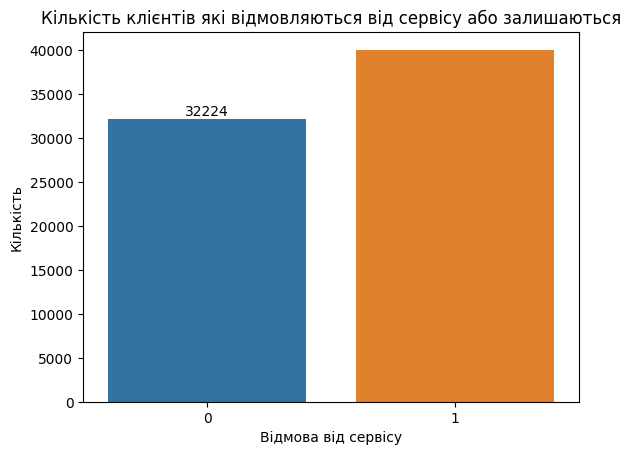

time: 2.09 s (started: 2024-10-16 13:38:13 +00:00)


In [ ]:
plt.title("Кількість клієнтів які відмовляються від сервісу або залишаються")
ax = sns.countplot(x='churn', data=df, palette="tab10")
ax.set(xlabel="Відмова від сервісу", ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()

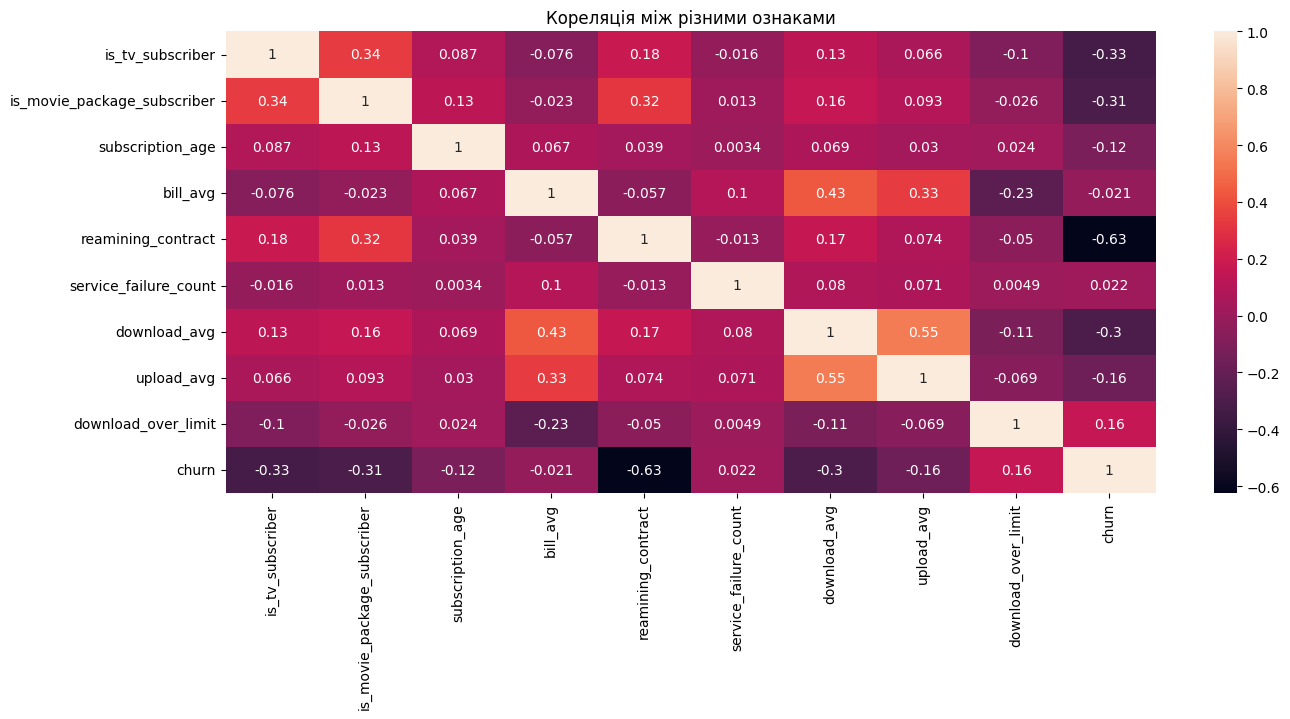

time: 2.23 s (started: 2024-10-16 13:38:15 +00:00)


In [ ]:
plt.figure(figsize=(15,6))
ax = sns.heatmap(df.corr(), annot=True)
plt.title("Кореляція між різними ознаками")
plt.show()

### Висновок

Найбільша кореліція відтоку (churn) спостерігається з наступними ознаками:
* reamining_contract (сильно, негативно)
* is_tv_subscriber (слабо, негативно)
* is_movie_package_subscriber (слабо, негативно)
* download_avg (слабо, негативно)

## Аналіз пустих даних

In [ ]:
df.isnull().sum(axis=0)

,0
is_tv_subscriber,0
is_movie_package_subscriber,0
subscription_age,0
bill_avg,0
reamining_contract,21572
service_failure_count,0
download_avg,381
upload_avg,381
download_over_limit,0
churn,0


time: 49.9 ms (started: 2024-10-16 13:38:17 +00:00)


In [ ]:
# вибираємо дані, де reamining_contract = 0
zero_contract_df = df[df['reamining_contract'] == 0]

time: 20.8 ms (started: 2024-10-16 13:38:17 +00:00)


In [ ]:
zero_contract_df.shape

(16363, 10)

time: 23.6 ms (started: 2024-10-16 13:38:17 +00:00)


In [ ]:
# вибираємо дані, де reamining_contract відсутннє
no_contract_df = df[df['reamining_contract'].isnull()]

time: 13.9 ms (started: 2024-10-16 13:38:17 +00:00)


In [ ]:
no_contract_df.shape

(21572, 10)

time: 16.9 ms (started: 2024-10-16 13:38:17 +00:00)


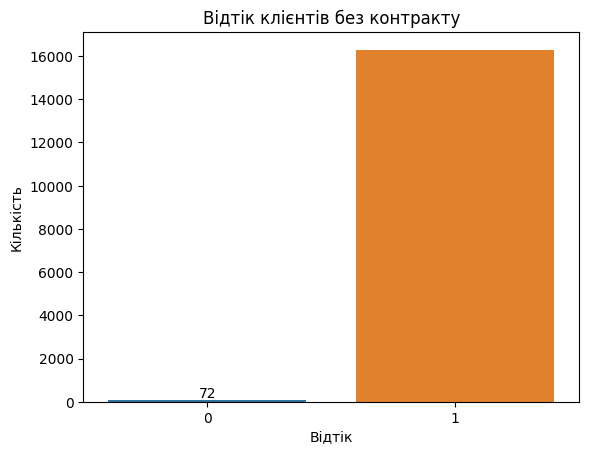

churn
1    16291
0       72
Name: count, dtype: int64
time: 730 ms (started: 2024-10-16 13:38:17 +00:00)


In [ ]:
plt.title("Відтік клієнтів без контракту")
ax = sns.countplot(x='churn', data=zero_contract_df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()
print(zero_contract_df['churn'].value_counts())

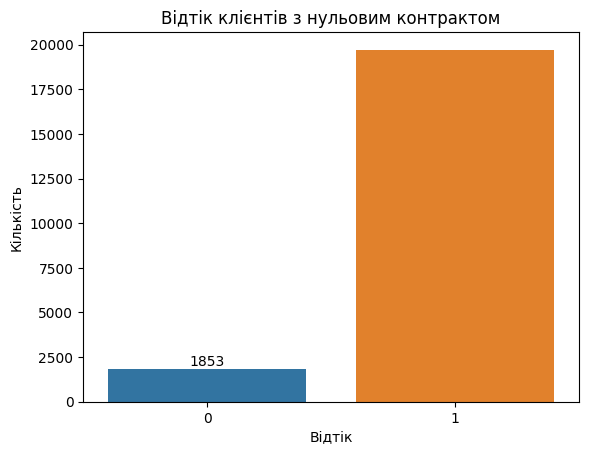

churn
1    19719
0     1853
Name: count, dtype: int64
time: 625 ms (started: 2024-10-16 13:38:18 +00:00)


In [ ]:
plt.title("Відтік клієнтів з нульовим контрактом")
ax = sns.countplot(x='churn', data=no_contract_df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()
print(no_contract_df['churn'].value_counts())

### Висновок

* Дані в стовпчику "reamining_contract" сильно впливають на значення відтоку ('churn').
* При цьому відсутність даних і нульове значення впливають приблизно однакомо, тому відсутні значення можна замінити на 0.
* Пустими значеннями для download_avg та upload_avg можна знехтувати.

In [ ]:
df["reamining_contract"] = df["reamining_contract"].replace(np.nan, 0.0)

time: 15.7 ms (started: 2024-10-16 13:38:19 +00:00)


Пустими значеннями для download_avg та upload_avg можна знехтувати.

In [ ]:
df.dropna(inplace=True)

time: 9.06 ms (started: 2024-10-16 13:38:19 +00:00)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71893 entries, 0 to 72273
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             71893 non-null  int64  
 1   is_movie_package_subscriber  71893 non-null  int64  
 2   subscription_age             71893 non-null  float64
 3   bill_avg                     71893 non-null  int64  
 4   reamining_contract           71893 non-null  float64
 5   service_failure_count        71893 non-null  int64  
 6   download_avg                 71893 non-null  float64
 7   upload_avg                   71893 non-null  float64
 8   download_over_limit          71893 non-null  int64  
 9   churn                        71893 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 6.0 MB
time: 11.9 ms (started: 2024-10-16 13:38:19 +00:00)


In [ ]:
df.isnull().sum(axis = 0)

,0
is_tv_subscriber,0
is_movie_package_subscriber,0
subscription_age,0
bill_avg,0
reamining_contract,0
service_failure_count,0
download_avg,0
upload_avg,0
download_over_limit,0
churn,0


time: 9.81 ms (started: 2024-10-16 13:38:19 +00:00)


In [ ]:
# plt.figure(figsize=(15,6))
# sns.heatmap(df.corr(), annot=True)

time: 372 µs (started: 2024-10-16 13:38:19 +00:00)


## Аналіз залежності відтоку клієнтів з ТВ підпискою та підпискою на пакет кіно

(is_tv_subscriber, is_movie_package_subscriber)

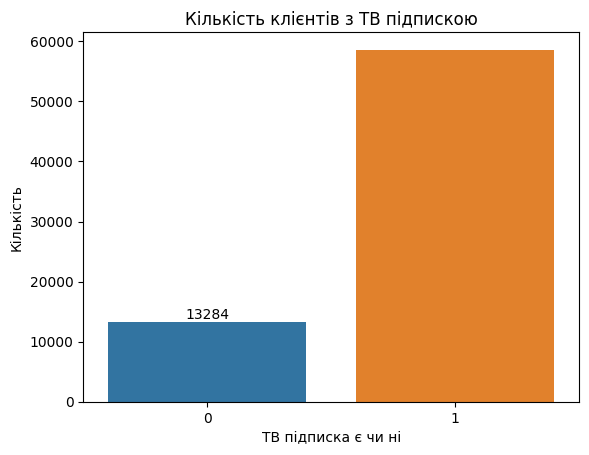

time: 844 ms (started: 2024-10-16 13:38:19 +00:00)


In [ ]:
plt.title("Кількість клієнтів з ТВ підпискою")
ax = sns.countplot(x='is_tv_subscriber', data=df, palette="tab10")
ax.set(xlabel="ТВ підписка є чи ні")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()

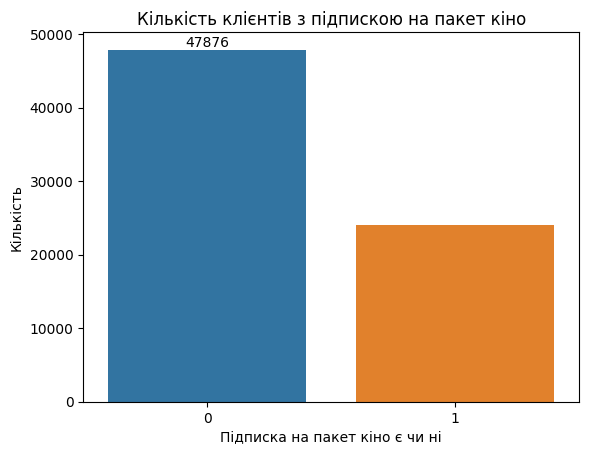

time: 771 ms (started: 2024-10-16 13:38:20 +00:00)


In [ ]:
plt.title("Кількість клієнтів з підпискою на пакет кіно")
ax = sns.countplot(x='is_movie_package_subscriber', data=df, palette="tab10")
ax.set(xlabel="Підписка на пакет кіно є чи ні")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()

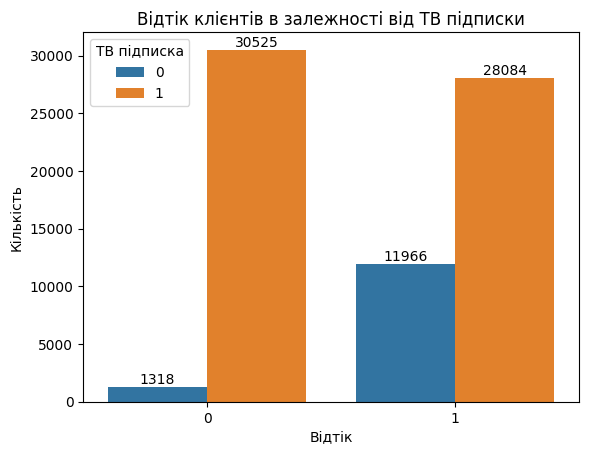

time: 1.02 s (started: 2024-10-16 13:38:21 +00:00)


In [ ]:
plt.title("Відтік клієнтів в залежності від ТВ підписки")
ax = sns.countplot(x='churn', data=df, hue="is_tv_subscriber")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="ТВ підписка")
plt.show()

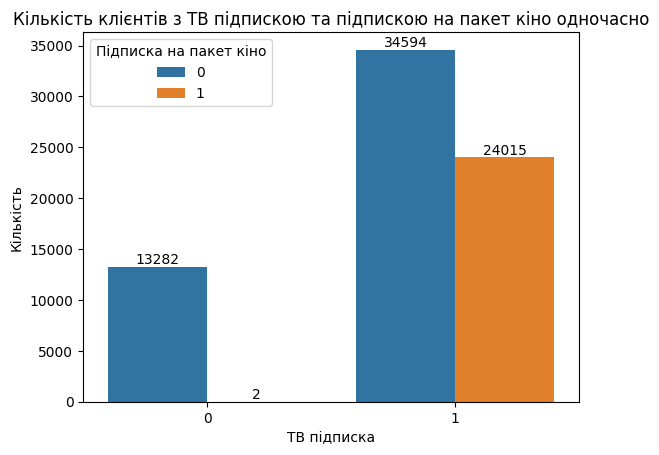

time: 978 ms (started: 2024-10-16 13:38:22 +00:00)


In [ ]:
plt.title("Кількість клієнтів з ТВ підпискою та підпискою на пакет кіно одночасно")
ax = sns.countplot(x='is_tv_subscriber', data=df, hue="is_movie_package_subscriber")
ax.set(xlabel="ТВ підписка")
ax.set(ylabel="Кількість")
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="Підписка на пакет кіно")
plt.show()

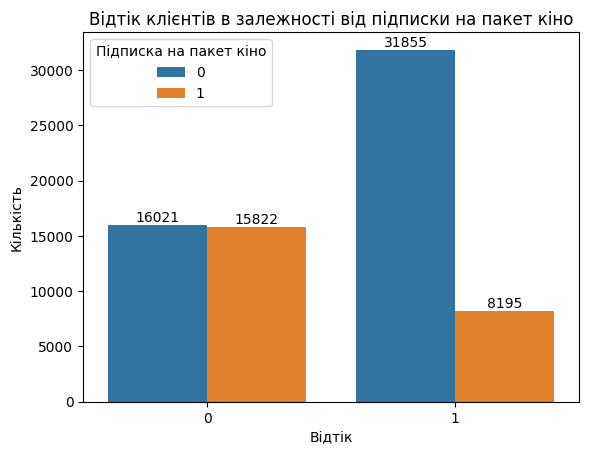

time: 792 ms (started: 2024-10-16 13:38:23 +00:00)


In [ ]:
plt.title("Відтік клієнтів в залежності від підписки на пакет кіно")
ax = sns.countplot(x='churn', data=df, hue="is_movie_package_subscriber")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="Підписка на пакет кіно")
plt.show()

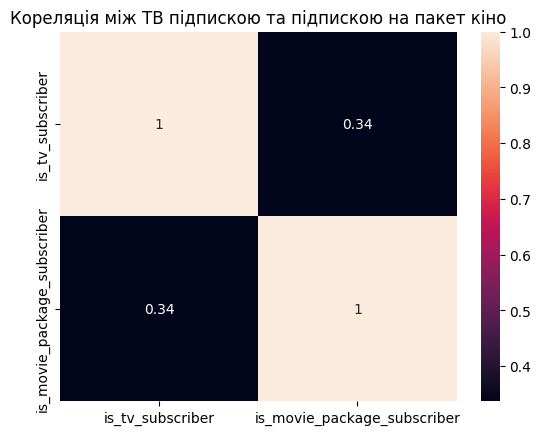

time: 584 ms (started: 2024-10-16 13:38:23 +00:00)


In [ ]:
plt.title("Кореляція між ТВ підпискою та підпискою на пакет кіно")
ax = sns.heatmap(df[['is_tv_subscriber', 'is_movie_package_subscriber']].corr(), annot=True)
plt.show()

### Висновок

По ТВ підписці (is_tv_subscriber=1):

* Кількість клієнтів з ТВ підпискою набагато більша, ніж без неї
* Клієнти з активною ТВ підпискою більше схильні до відтоку

Тобто: цей параметр <u>важливий</u> для аналізу

По підписці на пакет кіно (is_movie_package_subscriber=1):

* Клієнтів з активною підпискою на пакет кіно набагато меньше ніж без неї
* Підписка на пакет кіно сильно залежить від ТВ підписки

Тобто: цей параметр <u>не важливий</u> для аналізу


Також спостерігається кореляція між цими двома категріями

## Аналіз залежності відтоку клієнтів від об'єму трафіку

(download_avg, upload_avg)

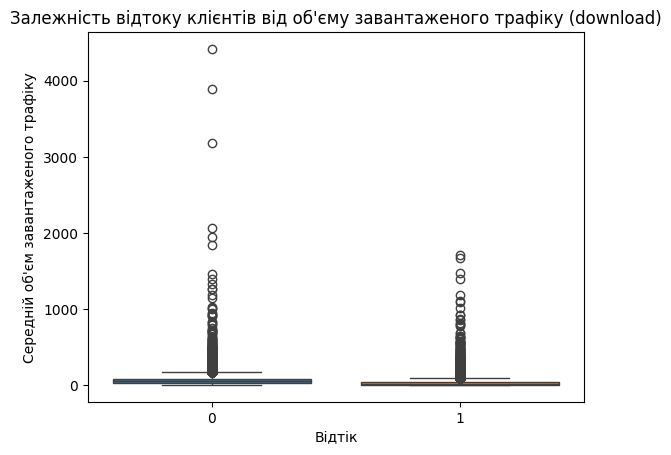

time: 607 ms (started: 2024-10-16 13:38:24 +00:00)


In [ ]:
plt.title("Залежність відтоку клієнтів від об'єму завантаженого трафіку (download)")
ax = sns.boxplot(x='churn', y='download_avg', data=df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Середній об'єм завантаженого трафіку")
plt.show()

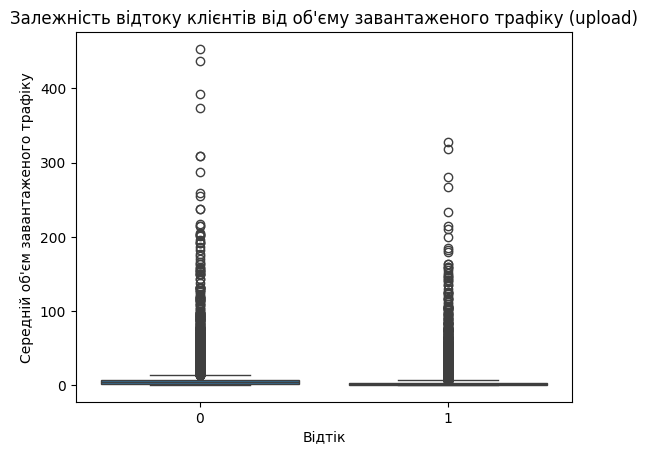

time: 1.44 s (started: 2024-10-16 13:38:25 +00:00)


In [ ]:
plt.title("Залежність відтоку клієнтів від об'єму завантаженого трафіку (upload)")
ax = sns.boxplot(x='churn', y='upload_avg', data=df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Середній об'єм завантаженого трафіку")
plt.show()

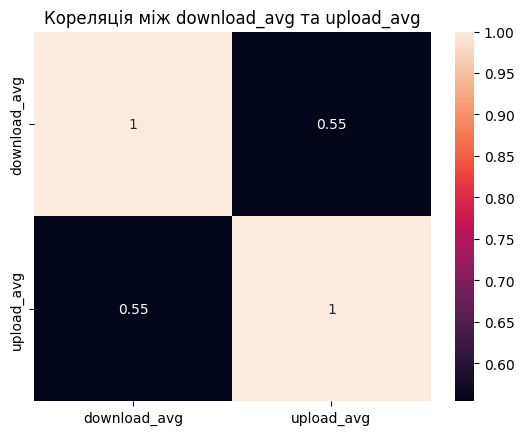

time: 813 ms (started: 2024-10-16 13:38:26 +00:00)


In [ ]:
plt.title("Кореляція між download_avg та upload_avg")
ax = sns.heatmap(df[['download_avg', 'upload_avg']].corr(), annot=True)
plt.show()

### Висновок

* Об'єм завантаженого трафіку (як download_avg так і upload_avg) не сильно впливає на відтік.
* Спостерігається кореляція між цими двома категріями
* Клієнти зі значним об'ємом завантаженого трафіку (як download_avg так і upload_avg) меньш схильні до відтоку, але їх кількість занадто мала, щоб враховувати це як окремий фактор.


## Додаткова перевірка

In [ ]:
from sklearn.feature_selection import mutual_info_classif
x = df.drop(columns=["churn"])
y = df["churn"]
important_features = mutual_info_classif(x, y, random_state=SEED)

time: 10.5 s (started: 2024-10-16 13:38:27 +00:00)


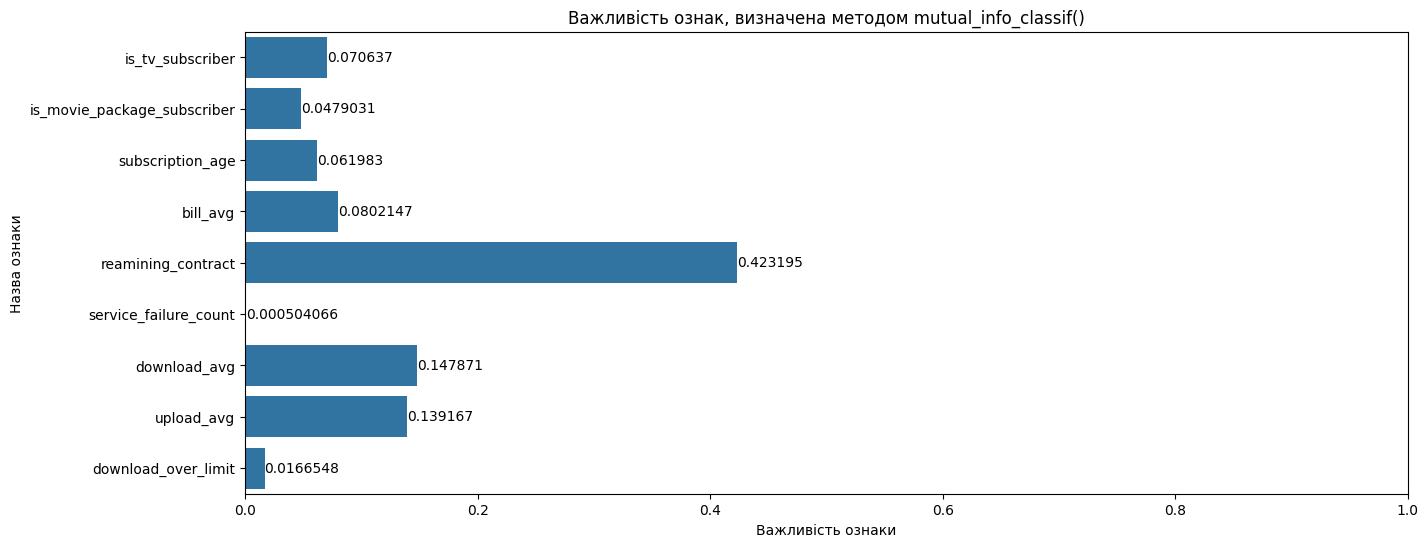

time: 673 ms (started: 2024-10-16 13:38:37 +00:00)


In [ ]:
plt.figure(figsize=(15,6))
ax = sns.barplot(important_features, orient ='h')
ax.set(xlabel="Важливість ознаки", ylabel="Назва ознаки")
ax.set_xlim(0, 1)
ax.set_yticklabels(x.columns)
ax.bar_label(ax.containers[0])
ax.set_title("Важливість ознак, визначена методом mutual_info_classif()")
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest

best_features = SelectKBest(k="all")
fit = best_features.fit(df.drop(columns=["churn"]), df["churn"])

time: 51.3 ms (started: 2024-10-16 13:38:38 +00:00)


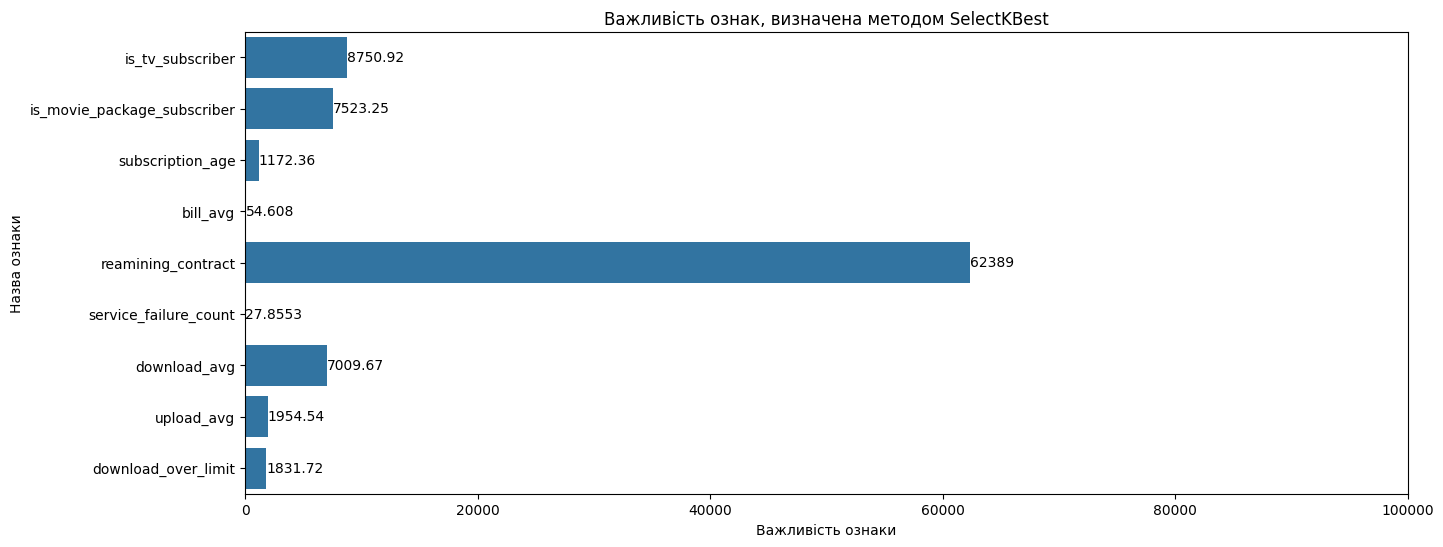

time: 625 ms (started: 2024-10-16 13:38:38 +00:00)


In [ ]:
plt.figure(figsize=(15,6))
ax = sns.barplot(fit.scores_, orient ='h')
ax.set(xlabel="Важливість ознаки", ylabel="Назва ознаки")
ax.set_xlim(0, 100000)
ax.set_yticklabels(x.columns)
ax.bar_label(ax.containers[0])
ax.set_title("Важливість ознак, визначена методом SelectKBest")
plt.show()

## Висновок

Важливими ознаками для прогнозування відтоку клієнтів є:
* reamining_contract
* is_tv_subscriber


# Моделювання




In [ ]:
X = df.drop(columns=["churn"])
y = df["churn"]

time: 15 ms (started: 2024-10-16 13:38:39 +00:00)


In [ ]:
# # test
# X = df[['reamining_contract', 'is_tv_subscriber']]
# y = df["churn"]

# # test results on the best model: 0.9237777314138674

time: 296 µs (started: 2024-10-16 13:38:39 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=SEED,
                                                    shuffle=True,
                                                    stratify=y
                                                    )

time: 50.9 ms (started: 2024-10-16 13:38:39 +00:00)


In [ ]:
print(y_train.value_counts())

churn
1    32040
0    25474
Name: count, dtype: int64
time: 4.69 ms (started: 2024-10-16 13:38:39 +00:00)


## RandomForest

In [ ]:
def RF_grid_search(X_train, y_train):
  # Створення класифікатора Random Forest
  model = RandomForestClassifier(n_jobs=-1, random_state=SEED)

  # Визначення сітки гіперпараметрів для перебору
  param_grid = {
      'n_estimators': [50, 75, 100],
      # 'criterion': ['gini', 'entropy', 'log_loss'],
      'max_features': ['sqrt', 'log2'],
      'max_depth': [None, 5, 10],
      'min_samples_leaf': [1, 2]
  }

  # Створення об'єкта GridSearchCV
  gridsearch = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=3,
                            scoring='accuracy'
                            )

  gridsearch.fit(X_train, y_train)

  return gridsearch

time: 931 µs (started: 2024-10-16 13:38:39 +00:00)


In [ ]:
def show_gridsearch_results(name, gridsearch):

  # Оцінка точності моделі з найкращими параметрами
  best_model = gridsearch.best_estimator_
  y_pred = best_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  plt.figure(figsize=(18, 6))
  # Матриця плутанини
  plt.subplot(1, 3, 1)
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
  plt.title(f'Confusion Matrix - {name}')

  # PR-крива
  plt.subplot(1, 3, 2)
  precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])
  plt.plot(recall, precision, color='b', label='PR Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision-Recall Curve - {name}')
  plt.legend()

  # ROC-крива
  plt.subplot(1, 3, 3)
  fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='r', label=f'ROC Curve (AUC = {roc_auc:.2f})')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve - {name}')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Вивід найкращих знайдених гіперпараметрів
  print("\nНайкращі параметри:", gridsearch.best_params_, "\n\n")

  # Точність найкращої моделі
  print(f"Точність моделі з найкращими параметрами: {accuracy}\n\n")

  print(classification_report(y_test, y_pred))

time: 2.41 ms (started: 2024-10-16 13:38:39 +00:00)


### Classic

In [ ]:
classic_RF_gridsearch = RF_grid_search(X_train, y_train)

time: 5min 15s (started: 2024-10-16 13:38:39 +00:00)


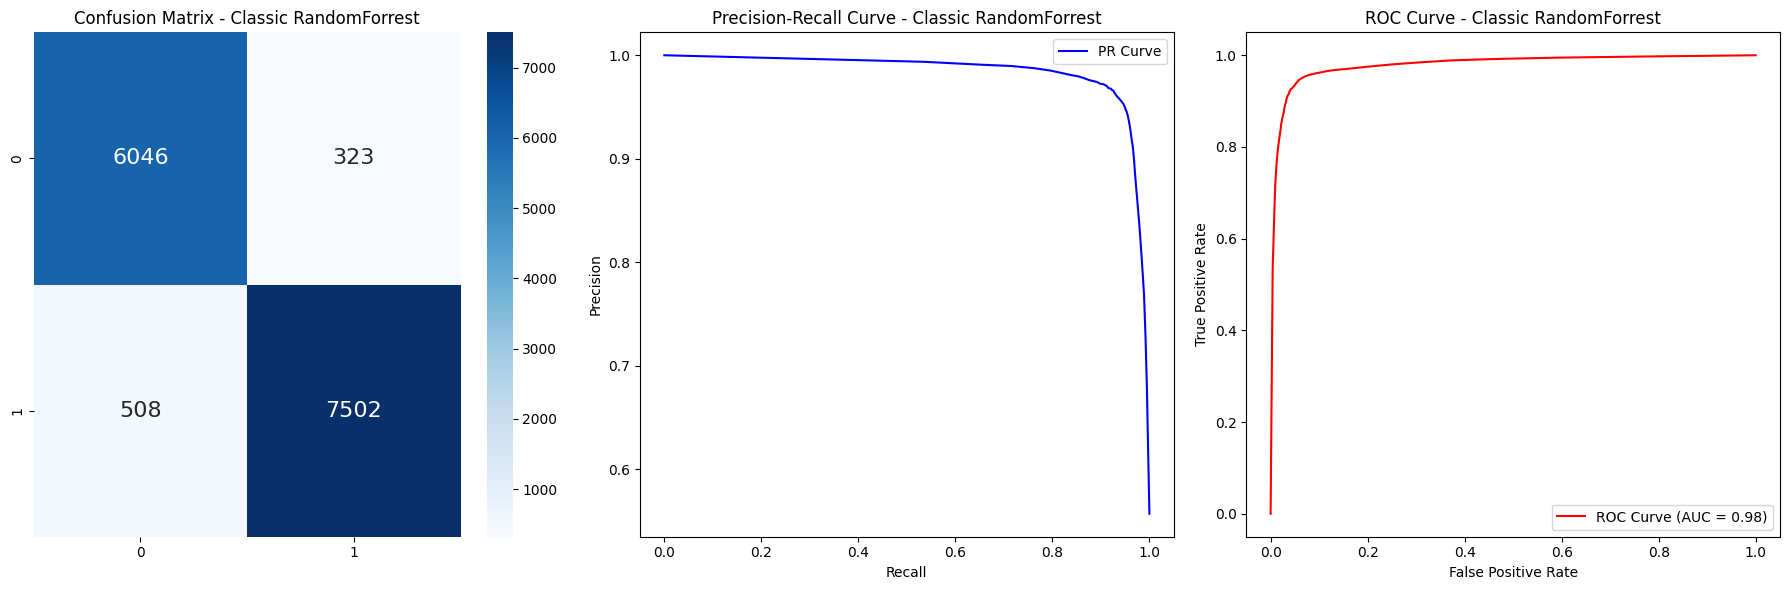


Найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50} 


Точність моделі з найкращими параметрами: 0.9422073857709159


              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6369
           1       0.96      0.94      0.95      8010

    accuracy                           0.94     14379
   macro avg       0.94      0.94      0.94     14379
weighted avg       0.94      0.94      0.94     14379

time: 1.15 s (started: 2024-10-16 13:43:54 +00:00)


In [ ]:
show_gridsearch_results("Classic RandomForrest", classic_RF_gridsearch)

Висновок:

найкращі параметри показала модель у якої майже всі гіперпараметри за замовчанням

навіть зменшена кількість естиматорів (у порівнянні з дефолтним 100)

time: 1.16 s (started: 2024-10-16 13:43:54 +00:00)


### Scaling

In [ ]:
# Scaling
# scaler = StandardScaler()
scaler = MinMaxScaler()
# x_scaled = scaler.fit_transform(X_train) ### <-- неправильно

time: 952 µs (started: 2024-10-16 13:43:56 +00:00)


In [ ]:
# скейлити треба тільки небінарні дані
columns_to_scale = ['subscription_age', 'bill_avg', 'reamining_contract', 'service_failure_count', 'download_avg', 'upload_avg', 'download_over_limit']
x_scaled = scaler.fit_transform(X_train[columns_to_scale])

time: 17.5 ms (started: 2024-10-16 13:43:56 +00:00)


In [ ]:
x_scaled.shape

(57514, 7)

time: 2.75 ms (started: 2024-10-16 13:43:56 +00:00)


In [ ]:
df_scaled = X_train[:]
df_scaled[columns_to_scale] = x_scaled
df_scaled

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit
55807,1,1,0.156006,0.024631,0.000000,0.0,0.000000,0.000000,0.0
64140,1,1,0.056942,0.073892,0.431507,0.0,0.022309,0.021645,0.0
68990,1,1,0.017941,0.044335,0.602740,0.0,0.002152,0.003565,0.0
16904,1,1,0.523401,0.036946,0.315068,0.0,0.024665,0.027247,0.0
5440,1,0,0.294852,0.056650,0.000000,0.0,0.002288,0.001528,0.0
...,...,...,...,...,...,...,...,...,...
36630,1,0,0.131045,0.054187,0.000000,0.0,0.001065,0.001273,0.0
43888,1,1,0.199688,0.029557,0.000000,0.0,0.017621,0.008658,0.0
25736,0,0,0.051482,0.041872,0.000000,0.0,0.000000,0.000000,0.0
11386,1,1,0.540562,0.036946,0.441781,0.0,0.035242,0.015788,0.0


time: 49.9 ms (started: 2024-10-16 13:43:56 +00:00)


In [ ]:
scaled_RF_gridsearch = RF_grid_search(df_scaled, y_train)

time: 4min 48s (started: 2024-10-16 13:43:56 +00:00)


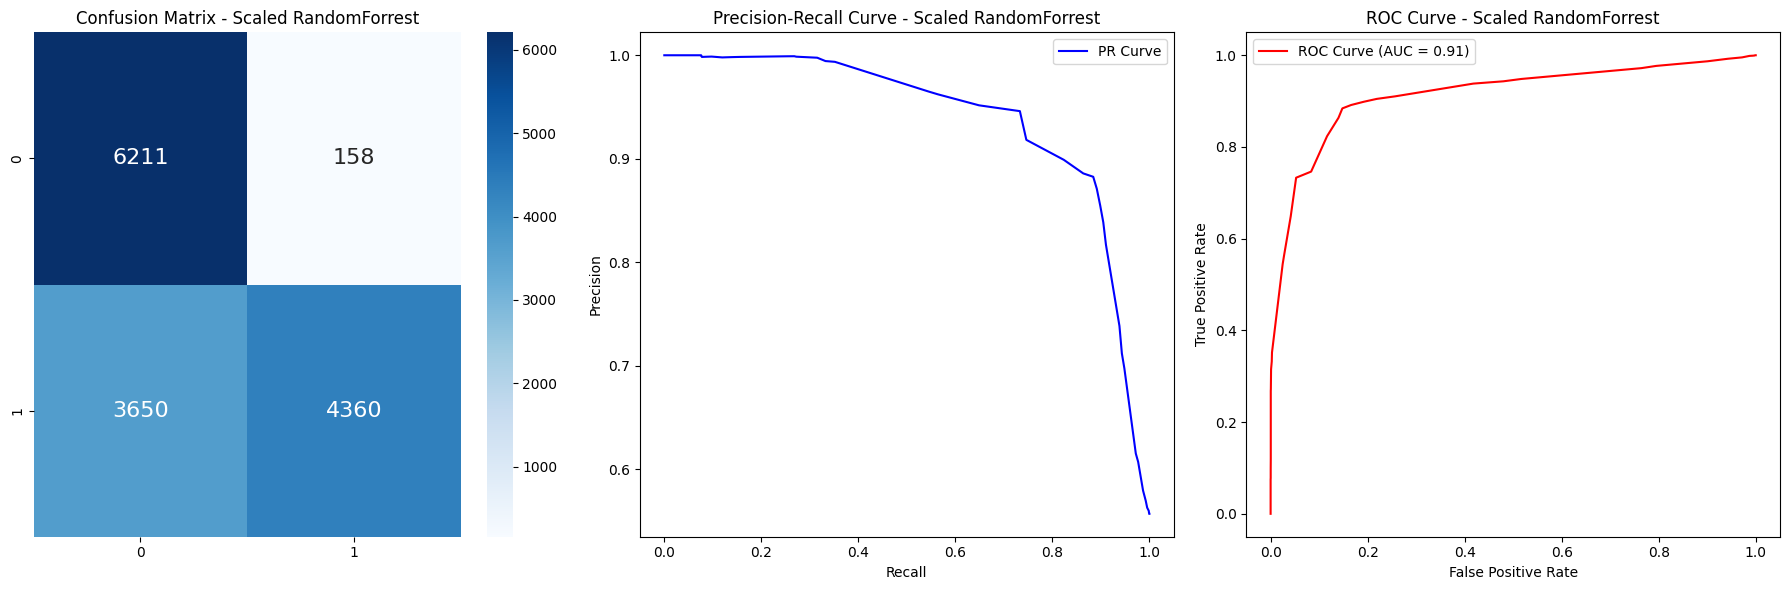


Найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50} 


Точність моделі з найкращими параметрами: 0.7351693441824884


              precision    recall  f1-score   support

           0       0.63      0.98      0.77      6369
           1       0.97      0.54      0.70      8010

    accuracy                           0.74     14379
   macro avg       0.80      0.76      0.73     14379
weighted avg       0.82      0.74      0.73     14379

time: 1.24 s (started: 2024-10-16 13:48:45 +00:00)


In [ ]:
show_gridsearch_results("Scaled RandomForrest", scaled_RF_gridsearch)

Висновок:

При використанні скейлінгу на числових параметрах різко виростає кількисть помилкових передбачень False Positives
Загальний результат точності набагато гірший ніж без скейлінгу

### Oversampled

In [ ]:
oversampler = SMOTE(random_state=SEED)
x_resample, y_resample = oversampler.fit_resample(X_train, y_train)

time: 533 ms (started: 2024-10-16 13:48:46 +00:00)


In [ ]:
oversampled_RF_gridsearch = RF_grid_search(x_resample, y_resample)

time: 5min 48s (started: 2024-10-16 13:48:47 +00:00)


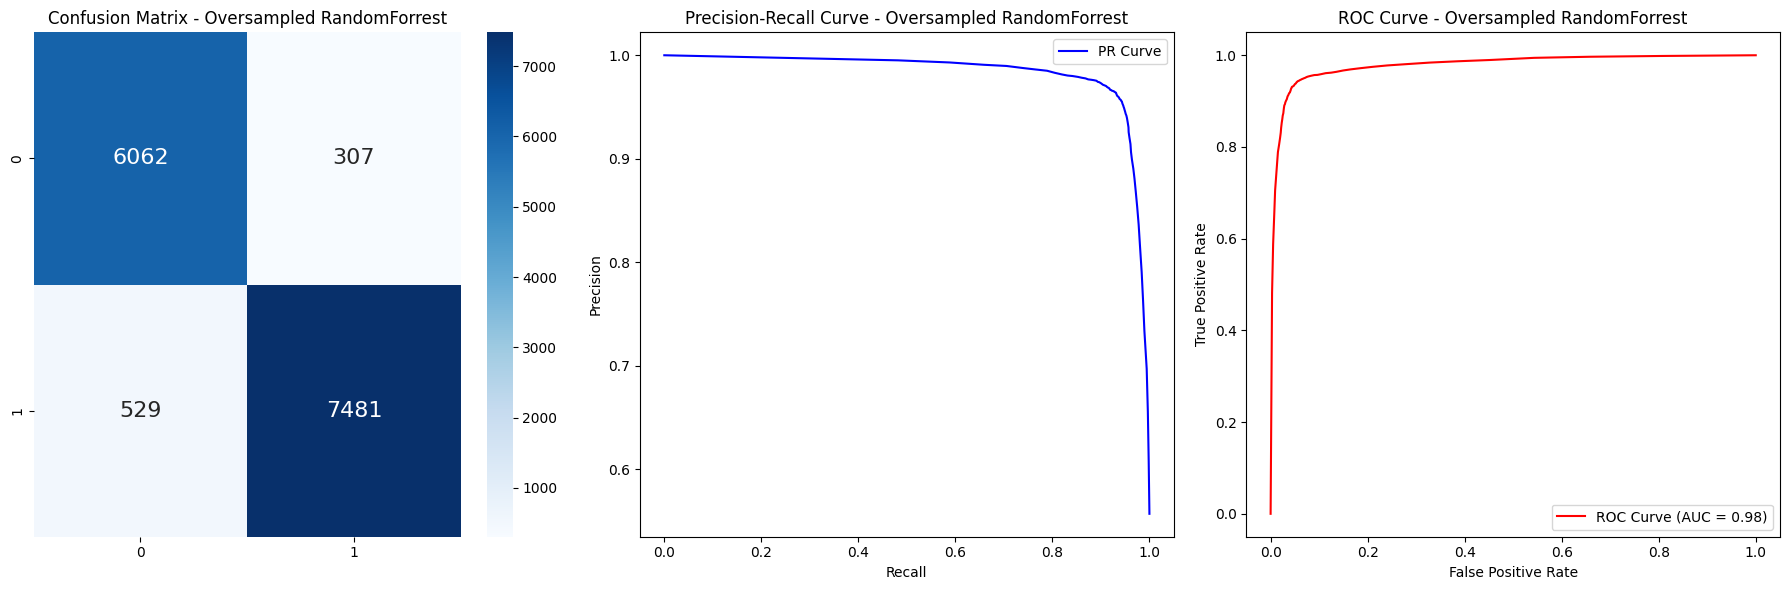


Найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 75} 


Точність моделі з найкращими параметрами: 0.9418596564434244


              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6369
           1       0.96      0.93      0.95      8010

    accuracy                           0.94     14379
   macro avg       0.94      0.94      0.94     14379
weighted avg       0.94      0.94      0.94     14379

time: 1.28 s (started: 2024-10-16 13:54:35 +00:00)


In [ ]:
show_gridsearch_results("Oversampled RandomForrest", oversampled_RF_gridsearch)

Висновок:

найкращою вибрана модель з дефолтними гіперпараметрами

oversampling практично не впливає на точність прогнозу

в порівнянні з класичним RF спостерігаєтсья погіршення accuracy на 0.02%

# Save best model

In [ ]:
joblib.dump(classic_RF_gridsearch, f"{MODELS_PATH}/classic_RF_gridsearch.bin")

['/content/gdrive/MyDrive/Colab Notebooks/Project Prognosis/classic_RF_gridsearch.bin']

time: 212 ms (started: 2024-10-16 14:27:18 +00:00)


In [ ]:
joblib.dump(classic_RF_gridsearch.best_estimator_, f"{MODELS_PATH}/classic_RF_model.pkl")

['/content/gdrive/MyDrive/Colab Notebooks/Project Prognosis/classic_RF_model.pkl']

time: 406 ms (started: 2024-10-16 14:26:17 +00:00)


In [ ]:
classic_RF_gridsearch.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 50}

time: 3.46 ms (started: 2024-10-16 14:25:14 +00:00)


In [ ]:
classic_RF_gridsearch.best_estimator_

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

time: 41.8 ms (started: 2024-10-16 14:26:02 +00:00)


# Load saved model

In [ ]:
new_model = joblib.load(f"{MODELS_PATH}/classic_RF_model.pkl")

time: 330 ms (started: 2024-10-16 14:30:33 +00:00)


In [ ]:
new_model


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

time: 18 ms (started: 2024-10-16 14:30:45 +00:00)


In [ ]:
new_model.n_features_in_


9

time: 9.93 ms (started: 2024-10-16 14:33:31 +00:00)


In [ ]:
new_model.feature_names_in_

array(['is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'reamining_contract',
       'service_failure_count', 'download_avg', 'upload_avg',
       'download_over_limit'], dtype=object)

time: 6.64 ms (started: 2024-10-16 14:34:56 +00:00)


In [ ]:
new_model.classes_

array([0, 1])

time: 9.25 ms (started: 2024-10-16 14:33:50 +00:00)


In [ ]:
new_model.estimators_

[DecisionTreeClassifier(max_features='sqrt', random_state=1608637542),
 DecisionTreeClassifier(max_features='sqrt', random_state=1273642419),
 DecisionTreeClassifier(max_features='sqrt', random_state=1935803228),
 DecisionTreeClassifier(max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_features='sqrt', random_state=1201263687),
 DecisionTreeClassifier(max_features='sqrt', random_state=423734972),
 DecisionTreeClassifier(max_features='sqrt', random_state=415968276),
 DecisionTreeClassifier(max_features='sqrt', random_state=670094950),
 DecisionTreeClassifier(max_features='sqrt', random_state=1914837113),
 DecisionTreeClassifier(max_features='sqrt', random_state=669991378),
 DecisionTreeClassifier(max_features='sqrt', random_state=429389014),
 DecisionTreeClassifier(max_features='sqrt', random_state=249467210),
 DecisionTreeClassifier(max_features='sqrt', random_state=1972458954),
 DecisionTreeC

time: 25 ms (started: 2024-10-16 14:34:00 +00:00)
